In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import proplot as plot
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr

## 使用SRTMX,C-DEM计算 penetrate_cx每一景的C-X沿海拔的线性模型，存储到penetrate_cx_all_prj.gpkg中
使用xDEM corregistration

In [2]:
pth='D:\\Key_works\\20231212dh_calculate'
df_pene=gpd.read_file(pth+'\\penetrate_cx_all_prj.gpkg')
df_pene['x']=df_pene.geometry.x
df_pene['y']=df_pene.geometry.y

In [3]:
pth_dh='D:\\Key_works\\20231212dh_calculate\\results\\dh_coreg'
group_lst=[i.split('_')[0] for i in os.listdir(pth_dh) if i[-4:]=='.tif']

In [4]:
len(group_lst)

566

In [19]:
def get_nearp(df_pene,pt):
    x=pt[0]
    y=pt[1]
    dar=[]
    for idx,dfi in df_pene.iterrows():
        distt=((x-dfi['x'])**2+(y-dfi['y'])**2)**0.5
        eq=dfi['linear']
        dar.append([eq,distt,dfi['x'],dfi['y'],dfi['NMAD'],dfi['Zmin'],dfi['Zmax']])
    df=pd.DataFrame(dar,columns=['eq','dist','x','y','NMAD','Zmin','Zmax'])
    df.sort_values(by='dist',ascending=True,inplace=True)
    #print(df.iloc[0])
    for i in range(len(df)):
        #print(i)
        eq_ot=df.iloc[i]['eq']
        err=df.iloc[i]['NMAD']
        hmin=df.iloc[i]['Zmin']
        hmax=df.iloc[i]['Zmax']
        if eq_ot==None:
            continue
        else:
            break
    #print(eq_ot)
    try:
        ttt=eq_ot.split('X + (')
        k=float(ttt[0].split('=')[1])
        b=float(ttt[1].split(')')[0])
        
    except:
        ttt=eq_ot.split('X +(')
        k=float(ttt[0].split('=')[1])
        b=float(ttt[1].split(')')[0])
        
    return k,b,err,hmin,hmax

In [22]:
lss=[];pene_paint_lst=[]
for gpi in group_lst:
    #print(gpi)
    nm_dh=pth_dh+'/'+gpi+'_dh_coreg.tif'
    gla_nm=pth+'/gla/CGI1/'+gpi+'_gla.shp'
    nm_dem=pth+'/srtm/'+gpi+'_srtm.tif'
    
    df_glai=gpd.read_file(gla_nm)
    ds_dhi=xr.open_dataset(nm_dh,engine='rasterio')['band_data']
    ds_demi=xr.open_dataset(nm_dem,engine='rasterio')['band_data']
    ds_demi=ds_demi.interp(x=ds_dhi.x,y=ds_dhi.y,method='nearest')
    
    
    ds_demi_clp=ds_demi.rio.clip(df_glai.geometry,drop=False)
    ds_demi_clp.name='h'

    x=(ds_dhi.rio.bounds()[0]+ds_dhi.rio.bounds()[2])/2
    y=(ds_dhi.rio.bounds()[1]+ds_dhi.rio.bounds()[3])/2
    pti=[x,y]
    k,b,err,hmin,hmax=get_nearp(df_pene,pti)
    ####用于绘制区域的穿透图
    ds_demi_clp.values[ds_demi_clp.values>hmax]=hmax
    ds_demi_clp.values[ds_demi_clp.values<hmin]=hmin
    hi=ds_demi_clp.to_dataframe().dropna().drop('spatial_ref',axis=1)
    hi['penetrate']=hi['h']*k+b
    hi['group']=gpi
    pene_paint_lst.append(hi)
    #########################
    penei=ds_demi_clp*k+b
    penei=penei.fillna(0)
    penei.values[penei.values<-3]=-3
    ds_dhi_pene=ds_dhi+penei.values[0]
    lss.append([gpi,err])
    #aaaa
    outnm=pth+'\\results\\dh_coreg_xc\\'+gpi+'_dh_coreg_penexc.tif'
    ds_dhi_pene.rio.to_raster(outnm) #, compress='LZMA', tiled=True, dtype="float32"
pene_err=pd.DataFrame(lss,columns=['group','penetrate_error'])
pene_err.to_csv(pth+'\\results\\penetrate_error.csv')
pene_paint=pd.concat(pene_paint_lst,axis=0)
pene_paint.to_csv(pth+'\\results\\penetrate4paint.csv')
print('done!')

done!


In [ ]:
#pene_paint

In [23]:
pene_paint['penetrate'].min(),pene_paint['penetrate'].max(),pene_paint['penetrate'].mean()

(-27.783058, 12.287003, 2.0430648)

In [25]:
penei.values[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
ds_demi_clp

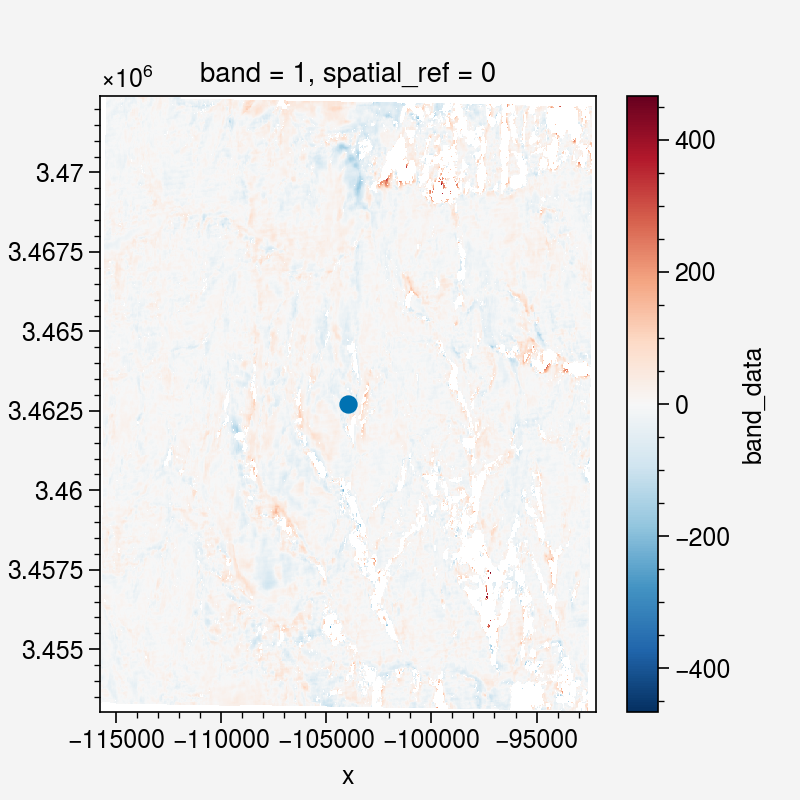

In [48]:
fig,ax=plt.subplots(1,1)
ds_dhi.plot(ax=ax)
ax.scatter(x,y)